In [39]:
import time, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv('/Users/jonny.sanchez/Documents/tesis/estaciones.csv',sep=";")
df.head()

,fuente,ciudad,codigo_estacion,fecha_toma,anio,mes,dia,medicion,sea_water,fresh_water,...,clouds,bare_ground,veg,lst,ndbi,ndvi,ndwi,st_emissivity,norte,este
0,dimar,barranquilla,0000000004,2020-03-29 07:00:00.000,2020,3,29,26.40,0.00,0.84,...,0.0,0.0,0.0,29.455811,-0.011720,-0.016581,0.002060,0.9880,2.785929e+06,4.798071e+06
1,dimar,barranquilla,0000000004,2021-02-12 13:00:00.000,2021,2,12,28.12,0.08,0.72,...,0.0,0.0,0.0,28.509033,-0.013787,0.060807,-0.105339,0.9880,2.785929e+06,4.798071e+06
2,dimar,barranquilla,0000000004,2022-02-23 13:00:00.000,2022,2,23,27.81,0.15,0.65,...,0.0,0.0,0.0,29.517365,-0.096698,0.052519,-0.084309,0.9880,2.785929e+06,4.798071e+06
3,dimar,barranquilla,0CP03FL033,2020-03-29 13:00:00.000,2020,3,29,28.50,0.00,0.28,...,0.0,0.0,0.0,36.818237,0.073587,0.277937,-0.362358,0.9669,2.778642e+06,4.801240e+06
4,dimar,barranquilla,0CP03FL033,2021-02-12 13:00:00.000,2021,2,12,28.60,0.00,0.28,...,0.0,0.2,0.0,34.975922,0.049616,0.316371,-0.368710,0.9669,2.778642e+06,4.801240e+06


In [41]:
df.dtypes

fuente              object
ciudad              object
codigo_estacion     object
fecha_toma          object
anio                 int64
mes                  int64
dia                  int64
medicion           float64
sea_water          float64
fresh_water        float64
builds             float64
clouds             float64
bare_ground        float64
veg                float64
lst                float64
ndbi               float64
ndvi               float64
ndwi               float64
st_emissivity      float64
norte              float64
este               float64
dtype: object

In [42]:
y = df['medicion'].values
X = df.drop(columns=['medicion','fuente','ciudad','codigo_estacion','fecha_toma'])

In [43]:
X.isnull().sum()

anio             0
mes              0
dia              0
sea_water        0
fresh_water      0
builds           0
clouds           0
bare_ground      0
veg              0
lst              0
ndbi             0
ndvi             0
ndwi             0
st_emissivity    0
norte            0
este             0
dtype: int64

In [44]:
X.head()

,anio,mes,dia,sea_water,fresh_water,builds,clouds,bare_ground,veg,lst,ndbi,ndvi,ndwi,st_emissivity,norte,este
0,2020,3,29,0.00,0.84,0.16,0.0,0.0,0.0,29.455811,-0.011720,-0.016581,0.002060,0.9880,2.785929e+06,4.798071e+06
1,2021,2,12,0.08,0.72,0.20,0.0,0.0,0.0,28.509033,-0.013787,0.060807,-0.105339,0.9880,2.785929e+06,4.798071e+06
2,2022,2,23,0.15,0.65,0.20,0.0,0.0,0.0,29.517365,-0.096698,0.052519,-0.084309,0.9880,2.785929e+06,4.798071e+06
3,2020,3,29,0.00,0.28,0.72,0.0,0.0,0.0,36.818237,0.073587,0.277937,-0.362358,0.9669,2.778642e+06,4.801240e+06
4,2021,2,12,0.00,0.28,0.52,0.0,0.2,0.0,34.975922,0.049616,0.316371,-0.368710,0.9669,2.778642e+06,4.801240e+06


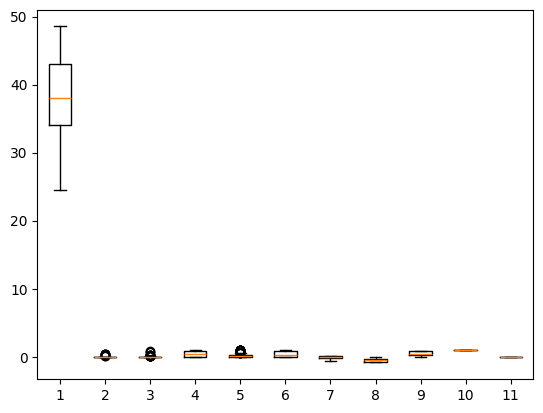

In [45]:
plt.boxplot((X["lst"],X["sea_water"],X["fresh_water"],X["builds"],X["bare_ground"],X["veg"],X["ndbi"],X["ndwi"],X["ndvi"],X["st_emissivity"],X["clouds"]))
plt.show()

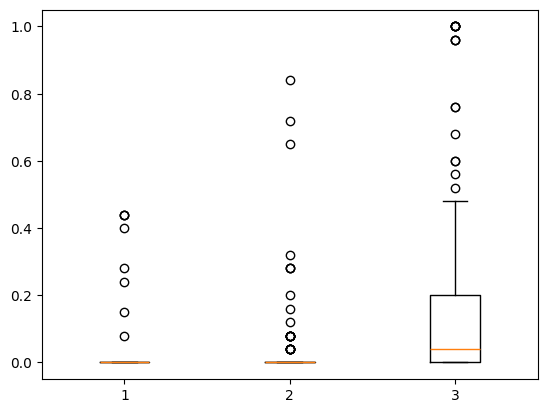

In [46]:
plt.boxplot((X["sea_water"],X["fresh_water"],X["bare_ground"]))
plt.show()

In [47]:
X.corr()

,anio,mes,dia,sea_water,fresh_water,builds,clouds,bare_ground,veg,lst,ndbi,ndvi,ndwi,st_emissivity,norte,este
anio,1.000000,-0.345780,0.566138,-0.045868,0.134415,-0.119407,NaN,0.074470,0.037747,-0.149283,-0.044302,0.044426,-0.046160,0.007985,0.040879,0.024340
mes,-0.345780,1.000000,-0.157516,-0.022794,0.057412,0.086383,NaN,0.156513,-0.198096,0.283334,0.190950,-0.187917,0.163228,-0.033903,0.022527,0.006876
dia,0.566138,-0.157516,1.000000,-0.002864,0.160600,-0.029915,NaN,0.053559,-0.050968,-0.035969,0.034709,-0.052140,0.047627,-0.036266,0.048100,0.026212
sea_water,-0.045868,-0.022794,-0.002864,1.000000,0.129362,0.004030,NaN,-0.066482,-0.185075,-0.241071,0.109857,-0.188445,0.163472,0.309195,0.272678,0.263197
fresh_water,0.134415,0.057412,0.160600,0.129362,1.000000,-0.095502,NaN,-0.119418,-0.137247,-0.270110,0.062034,-0.247165,0.279000,0.101980,0.101403,-0.035528
builds,-0.119407,0.086383,-0.029915,0.004030,-0.095502,1.000000,NaN,-0.305006,-0.745083,0.647291,0.730351,-0.821309,0.835764,-0.525759,-0.177787,-0.351701
clouds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bare_ground,0.074470,0.156513,0.053559,-0.066482,-0.119418,-0.305006,NaN,1.000000,-0.310846,0.255280,0.278811,-0.041976,-0.065024,-0.045490,0.057845,0.016080
veg,0.037747,-0.198096,-0.050968,-0.185075,-0.137247,-0.745083,NaN,-0.310846,1.000000,-0.673157,-0.929305,0.930157,-0.878625,0.453029,0.054784,0.291503
lst,-0.149283,0.283334,-0.035969,-0.241071,-0.270110,0.647291,NaN,0.255280,-0.673157,1.000000,0.761992,-0.624716,0.597062,-0.698593,-0.402927,-0.491047


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
models = {
    'LinearRegression' : (
        Pipeline([("scaler", StandardScaler()),("model",LinearRegression())]), 
        {}
    ),
    'RandomForestRegressor': (
        Pipeline([("model", RandomForestRegressor(random_state=42))]),
        {"model__n_estimators":[200], "model__max_depth":[None,8]}
    ), 
    'GradientBoostingRegressor': (
        Pipeline([("model", GradientBoostingRegressor(random_state=42))]),
        {"model__n_estimators":[250], "model__learning_rate":[0.05,0.1], "model__max_depth":[2,3]}
    ),
    'SVR': (
        Pipeline([("scaler", StandardScaler()), ("model", SVR())]),
        {"model__C": [1.0, 10.0], "model__epsilon": [0.1, 0.3], "model__kernel": ["rbf"]}
    ),
    'MLPRegressor': (
        Pipeline([("scaler", StandardScaler()), ("model", MLPRegressor(random_state=42, max_iter=3000))]),
        {"model__hidden_layer_sizes": [(64,), (64, 32)], "model__alpha": [1e-4, 1e-3]}
    ),
}

In [50]:
k          = 10
cv         = KFold(n_splits=k, shuffle=True, random_state=42)

results = []
fitted = {}

for name, (pipe, grid) in models.items():
    gs = GridSearchCV(pipe, grid, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=1, refit=True)
    tic = time.perf_counter()
    gs.fit(X_train, y_train)
    fit_time = round(time.perf_counter() - tic, 3)

    y_pred = gs.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_test, y_pred))
    r2 = float(r2_score(y_test, y_pred))

    with parallel_backend("threading"):
        tic = time.perf_counter()
        y_pred_oof = cross_val_predict(gs.best_estimator_, X, y, cv=cv, n_jobs=-1)
        cv_pred_time = round(time.perf_counter() - tic, 3)

    rmse_oof = float(np.sqrt(mean_squared_error(y, y_pred_oof)))
    mae_oof  = float(mean_absolute_error(y, y_pred_oof))
    r2_oof   = float(r2_score(y, y_pred_oof))

    print(f"\n=== {name} ===")
    print("Mejores params CV: ", gs.best_params_)
    print(f"Tiempo entrenamiento: {fit_time}s | Tiempo OOF-predict: {cv_pred_time}s")
    print(f"[TEST]   RMSE={rmse:.3f}  MAE={mae:.3f}  R2={r2:.3f}")
    print(f"[OOF-CV] RMSE={rmse_oof:.3f}  MAE={mae_oof:.3f}  R2={r2_oof:.3f}")

    results.append({
        "modelo": name,
        "best_params": gs.best_params_,
        "fit_time_s": fit_time,
        "cv_pred_time_s": cv_pred_time,
        "test_RMSE": rmse, "test_MAE": mae, "test_R2": r2,
        "oof_RMSE": rmse_oof, "oof_MAE": mae_oof, "oof_R2": r2_oof,
        "cv_best_RMSE": float(-gs.best_score_),
    })

    fitted[name] = gs.best_estimator_


=== LinearRegression ===
Mejores params CV:  {}
Tiempo entrenamiento: 0.025s | Tiempo OOF-predict: 0.029s
[TEST]   RMSE=0.807  MAE=0.676  R2=0.884
[OOF-CV] RMSE=0.949  MAE=0.742  R2=0.873

=== RandomForestRegressor ===
Mejores params CV:  {'model__max_depth': None, 'model__n_estimators': 200}
Tiempo entrenamiento: 1.632s | Tiempo OOF-predict: 0.625s
[TEST]   RMSE=1.082  MAE=0.689  R2=0.792
[OOF-CV] RMSE=0.715  MAE=0.549  R2=0.928

=== GradientBoostingRegressor ===
Mejores params CV:  {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 250}
Tiempo entrenamiento: 1.696s | Tiempo OOF-predict: 0.308s
[TEST]   RMSE=0.800  MAE=0.618  R2=0.886
[OOF-CV] RMSE=0.703  MAE=0.536  R2=0.930

=== SVR ===
Mejores params CV:  {'model__C': 10.0, 'model__epsilon': 0.3, 'model__kernel': 'rbf'}
Tiempo entrenamiento: 0.056s | Tiempo OOF-predict: 0.015s
[TEST]   RMSE=0.867  MAE=0.723  R2=0.866
[OOF-CV] RMSE=0.942  MAE=0.713  R2=0.875

=== MLPRegressor ===
Mejores params CV:  {'model_

In [51]:
best_model = fitted['GradientBoostingRegressor']

print(best_model)
print(fitted.keys())

Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=2, n_estimators=250,
                                           random_state=42))])
dict_keys(['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'SVR', 'MLPRegressor'])


In [ ]:
import rasterio
import os

def cargar_banda(path):
    with rasterio.open(path) as src:
        return src.read(), src.profile

def grilla_xy(profile):
    T = profile["transform"]
    W = profile["width"]
    H = profile["height"]
    xs = T.c + np.arange(W) * T.a
    ys = T.f + np.arange(H) * T.e
    X, Y = np.meshgrid(xs, ys)
    return X.astype("float32"), Y.astype("float32")

def read_resample(path, ref_profile):
    with rasterio.open(path) as src:
        if (src.width, src.height) != (ref_profile["width"], ref_profile["height"]) or src.transform != ref_profile["transform"]:
            data = src.read(
                out_shape=(1, ref_profile["height"], ref_profile["width"]),
                resampling=rasterio.enums.Resampling.nearest
            )
            return data.astype("float32")
        else:
            return src.read().astype("float32")

def clasificar_rasters(path_raiz, best_model):
    """
    Clasifica cada stack raster en 'path_raiz' con los modelos de best_models.
    Devuelve un diccionario de tiempos: {carpeta: {modelo: segs}}.
    """
    for folder_name in os.listdir(path_raiz):
        folder_path = os.path.join(path_raiz, folder_name)
        if os.path.isdir(folder_path):
            date = anio = mes = dia = sea_water = fresh_water = builds = clouds = bare_ground = veg = lst = ndbi = ndvi = ndwi = st_emissivity = None
            date = folder_name.split(sep='_')[3]
            anio_file = int(date[0:4])
            mes_file = int(date[4:6])
            dia_file = int(date[6:8])
            for file_name in os.listdir(folder_path):
                if file_name.endswith("c0_sea_water.TIF"):
                    sea_water = os.path.join(folder_path,file_name)
                elif file_name.endswith("c1_fresh_water.TIF"):
                    fresh_water = os.path.join(folder_path,file_name)
                elif file_name.endswith("c2_builds.TIF"):
                    builds = os.path.join(folder_path,file_name)
                elif file_name.endswith("c3_clouds.TIF"):
                    clouds = os.path.join(folder_path,file_name)
                elif file_name.endswith("c4_bare_ground.TIF"):
                    bare_ground = os.path.join(folder_path,file_name)
                elif file_name.endswith("c5_vegetation.TIF"):
                    veg = os.path.join(folder_path,file_name)
                elif file_name.endswith("LST.TIF"):
                    lst = os.path.join(folder_path,file_name)
                elif file_name.endswith("NDBI.TIF"):
                    ndbi = os.path.join(folder_path,file_name)
                elif file_name.endswith("NDVI.TIF"):
                    ndvi = os.path.join(folder_path,file_name)
                elif file_name.endswith("NDWI.TIF"):
                    ndwi = os.path.join(folder_path,file_name)
                elif file_name.endswith("ST_EMIS.TIF"):
                    st_emissivity = os.path.join(folder_path,file_name)

        # cargar y apilar
            sea_water, _ = cargar_banda(sea_water)
            fresh_water, _ = cargar_banda(fresh_water)
            builds, _ = cargar_banda(builds) 
            clouds, _ = cargar_banda(clouds) 
            bare_ground, _ = cargar_banda(bare_ground) 
            veg, _ = cargar_banda(veg) 
            lst, profile = cargar_banda(lst) 
            ndbi, _ = cargar_banda(ndbi) 
            ndvi, _ = cargar_banda(ndvi) 
            ndwi, _ = cargar_banda(ndwi) 
            st_emissivity, _ = cargar_banda(st_emissivity)

            assert sea_water.shape[1:] == fresh_water.shape[1:] == builds.shape[1:] == clouds.shape[1:] == bare_ground.shape[1:] == veg.shape[1:] == lst.shape[1:] == ndbi.shape[1:] == ndwi.shape[1:] == ndvi.shape[1:] == st_emissivity.shape[1:], "Las dimensiones no coinciden."
            _, H, W = lst.shape
            anio = np.full((1, H, W), anio_file, dtype='float32')
            mes = np.full((1, H, W), mes_file, dtype='float32')
            dia = np.full((1, H, W), dia_file, dtype='float32')
            este, norte = grilla_xy(profile)
            este = este[np.newaxis, :, :]
            norte = norte[np.newaxis, :, :]
          
            multiband = np.concatenate((anio, mes, dia, sea_water, fresh_water, builds, clouds, bare_ground, veg, lst, ndbi, ndvi, ndwi, st_emissivity, norte, este), axis=0)
            num_bands, alto, ancho = multiband.shape

            data = multiband.reshape(num_bands, -1).T
            columns = ['anio','mes','dia','sea_water','fresh_water','builds','clouds','bare_ground','veg','lst','ndbi','ndvi','ndwi','st_emissivity','norte','este']

            df = pd.DataFrame(data, columns=columns)

            preds = best_model.predict(df)
            classification = preds.reshape(alto, ancho)

            profile.update(dtype=rasterio.float32, count=1, height=alto, width=ancho, nodata = np.nan)
            out_path = os.path.join(folder_path,"heat_island.TIF")

            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(classification.astype("float32"), 1)
            print("Procesado: ", out_path)

In [58]:
path = '/Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena'
clasificar_rasters(path,best_model)

Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20230117_20230131_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20210212_20220526_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20240120_20240129_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20200329_20200822_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20160114_20200907_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_010053_20220222_20220302_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP_009053_20180204_20200902_02_T1/heat_island.TIF
Procesado:  /Users/jonny.sanchez/Documents/tesis/10-heat_island/cartagena/LC08_L2SP